# Delta tables with Pandas

Documentation of library [deltalake](https://delta-io.github.io/delta-rs/python/)

In [1]:
!pip install deltalake
!mkdir /lake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 5.2 MB/s 
     |████████████████████████████████| 35.4 MB 1.3 MB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.
db-dtypes 1.0.4 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.


In [2]:
import pandas as pd
from deltalake import DeltaTable
from deltalake.writer import write_deltalake
import deltalake

Creating a DataFrame to use in the examples, data of ten people from Nevada, New York, and Pennsylvania:

In [3]:
dic = {
    'id': [1,2,3,4,5,6,7,8,9,10],
    'name':['James', 'Lindsey', 'Richard', 'Sophia', 'Emma', 'Noah', 'Johnny', 'Layla', 'Natalie', 'Luke'],
    'age': [20,22,26,18,30,36,19,24,45,30],
    'state': ['Nevada', 'New York', 'Pennsylvania', 'New York', 'Nevada', 'Pennsylvania', 'Pennsylvania', 'Nevada', 'New York', 'Pennsylvania']
}
df = pd.DataFrame(dic)
df.set_index('id', inplace = True)
df

,name,age,state
id,,,
1,James,20,Nevada
2,Lindsey,22,New York
3,Richard,26,Pennsylvania
4,Sophia,18,New York
5,Emma,30,Nevada
6,Noah,36,Pennsylvania
7,Johnny,19,Pennsylvania
8,Layla,24,Nevada
9,Natalie,45,New York


# Writing, reading, and checking out the metadata of the Delta table with Pandas



***Saving the Delta Table from Pandas dataframe***\
We will simulate a process of ingestion by batch, for it I divided the dataframe in three dataframes:

`df_nevada` : A delta table will be created from this dataframe\
`df_new_york` : It will append this dataframe into the delta table created as the first batch\
df_pennsylvania: It will append this dataframe into the delta table created as the second batch

In [13]:
df_nevada = df[df['state'] == 'Nevada']
df_new_york = df[df['state'] == 'New York']
df_pennsylvania = df[df['state'] == 'Pennsylvania']

Writing a delta table from Pandas dataframe with `write_deltalake`, it's possible to add a name, a description, and partition the delta table

`write_deltalake` has the `mode` parameter, which can be 'overwrite' or 'append'.


In [14]:
write_deltalake('/lake', df_nevada, 
                name= 'my_dataframe',
                description= 'dataframe created to demonstraction of Delta table with Pandas',
                partition_by= ['state']) 

The first batch, it appending the data of New Work into the delta table:

In [ ]:
write_deltalake('/lake', df_new_york,
                mode = 'append',
                partition_by=['state'])

The second batch, it appending the data of Pennsylvania into the delta table:

In [ ]:
write_deltalake('/lake', df_pennsylvania, 
               mode= 'append',
                partition_by=['state'])

**Reading a delta table**

To read the delta table is used the `DeltaTable` setting the path of the table and then use the `to_pandas()` function to transform the tabled read in a Pandas dataframe:

In [ ]:
dataframe = DeltaTable('/lake').to_pandas()
dataframe.set_index('id', inplace = True)
dataframe.head()

,name,age,state
id,,,
1,James,20,Nevada
5,Emma,30,Nevada
8,Layla,24,Nevada
2,Lindsey,22,New York
4,Sophia,18,New York


Sometimes that's don't work, because of the partitions. \
So we can specify the partitions and filter which partition we want to read it:

Just like that:
`partitions = ['state', '=', ['New York']]`



In [ ]:
dataframe = DeltaTable('/lake').to_pandas(
    partitions=[("state", "in", ["Nevada", "New York", 'Pennsylvania'])])

**Metadata of Delta Table:**

That action have to be before using the `to_pandas()`:

In [ ]:
print(DeltaTable('/lake').metadata())

Metadata(id: 78c58c08-a29d-484d-901c-4b7bca24c1fd, name: my_dataframe, description: dataframe created to demonstraction of Delta table with Pandas, partition_columns: ['state'], created_time: 1668268756925, configuration: {})


**The Schema of Delta Table:**

In [ ]:
DeltaTable('/lake').schema().to_pyarrow()

name: string
age: int64
state: string
id: int64

*** The history of Delta Table***

In [ ]:
DeltaTable('/lake').history()

[{'delta-rs': '0.4.1', 'timestamp': 1668268756925},
 {'clientVersion': 'delta-rs.0.4.1',
  'operation': 'delta-rs.Write',
  'operationParameters': {'mode': 'Append',
   'partitionBy': ['state'],
   'predicate': None},
  'timestamp': 1668268756956},
 {'clientVersion': 'delta-rs.0.4.1',
  'operation': 'delta-rs.Write',
  'operationParameters': {'mode': 'Append',
   'partitionBy': ['state'],
   'predicate': None},
  'timestamp': 1668268756987}]

# Time Travel

The Time Travel feature of Delta tables is incredible and we can use it in the Pandas. Always when the Delta table is changed, is created a new version of this table and we can travel through of the versions setting the version we want to access or state the table in a date specific, let's check out:

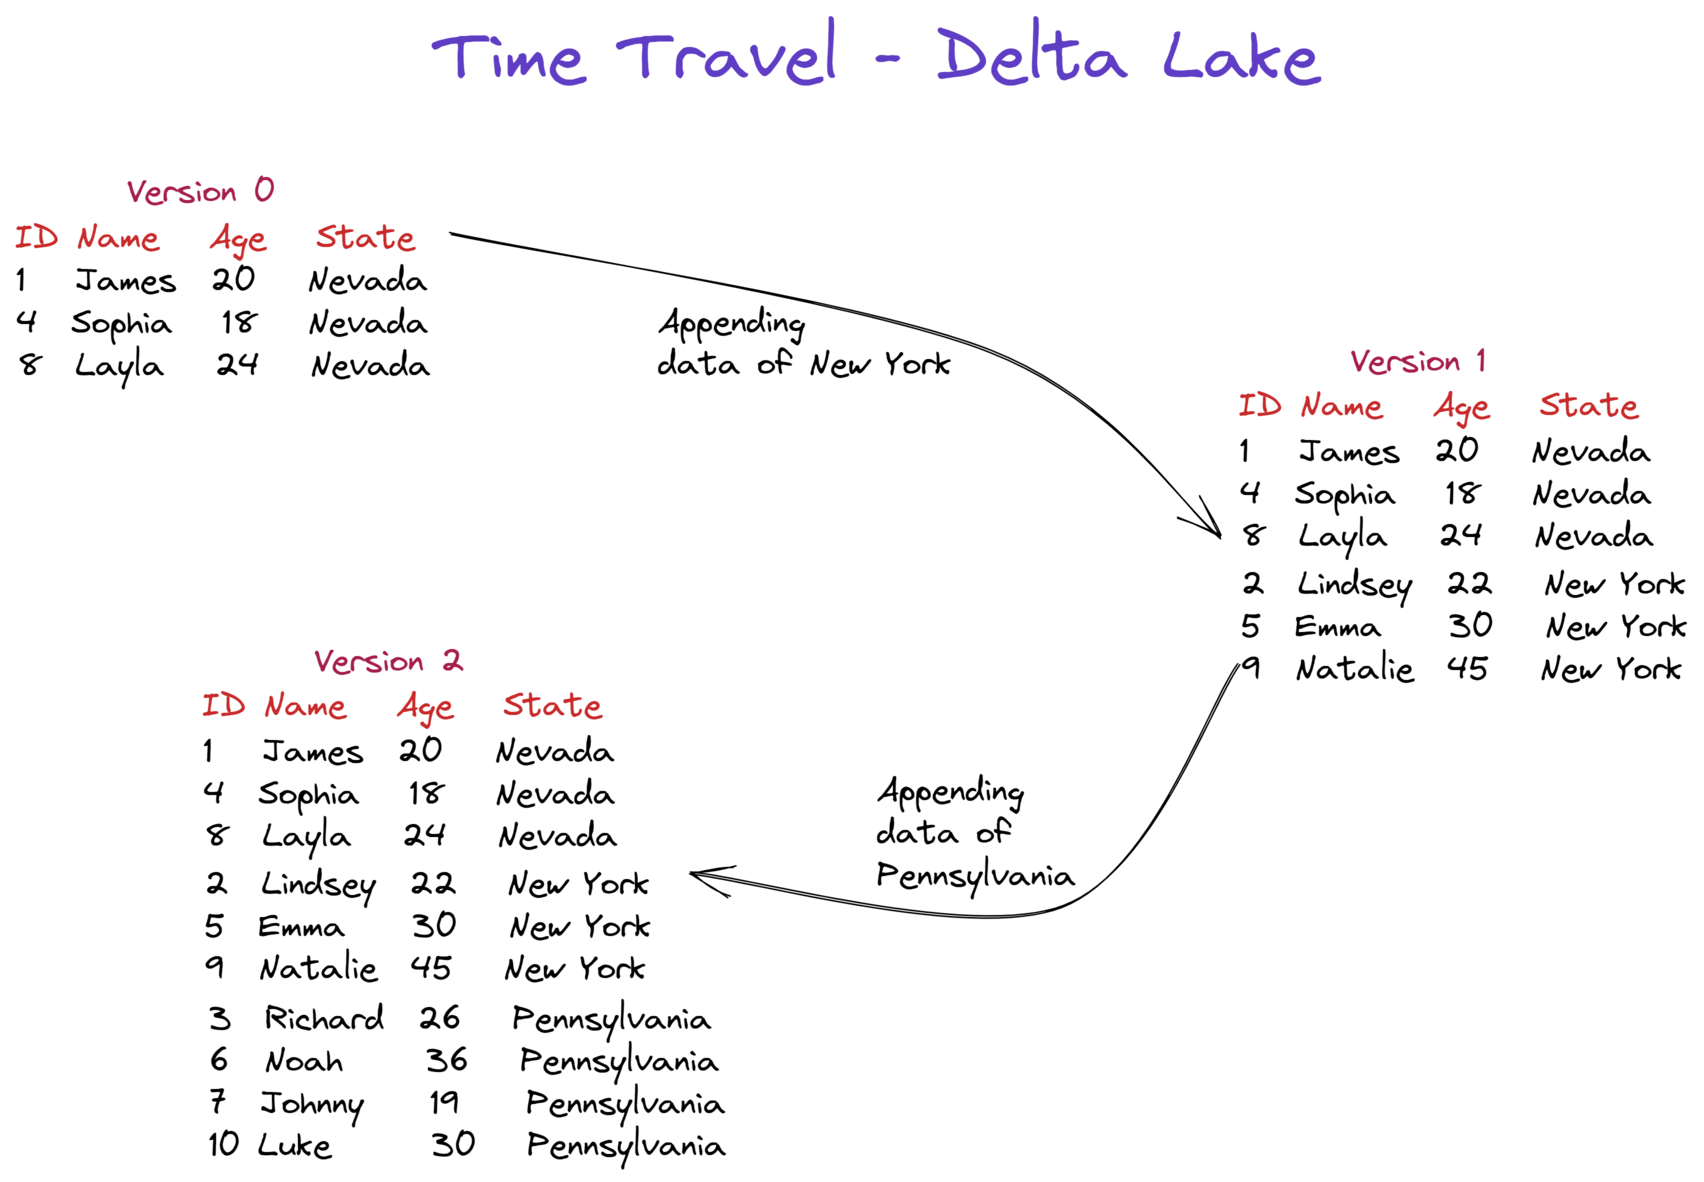

To read the delta table in a specific version, just set the version you want to read in the parameter `version`:

In [ ]:
df_v0 = DeltaTable('/lake', version = 0).to_pandas()
df_v1 = DeltaTable('/lake', version = 1).to_pandas()
df_v2 = DeltaTable('/lake', version = 2).to_pandas()

In [ ]:
df_v0

,name,age,state,id
0,James,20,Nevada,1
1,Emma,30,Nevada,5
2,Layla,24,Nevada,8


In [ ]:
df_v1

,name,age,state,id
0,James,20,Nevada,1
1,Emma,30,Nevada,5
2,Layla,24,Nevada,8
3,Lindsey,22,New York,2
4,Sophia,18,New York,4
5,Natalie,45,New York,9


In [ ]:
df_v2

,name,age,state,id
0,James,20,Nevada,1
1,Emma,30,Nevada,5
2,Layla,24,Nevada,8
3,Lindsey,22,New York,2
4,Sophia,18,New York,4
5,Natalie,45,New York,9
6,Richard,26,Pennsylvania,3
7,Noah,36,Pennsylvania,6
8,Johnny,19,Pennsylvania,7
9,Luke,30,Pennsylvania,10


Another mode to access a specific version, is using the attribute `load_version`:

In [ ]:
df_v1 = DeltaTable('/lake')
df_v1.load_version(1)
df_v1.to_pandas()

,name,age,state,id
0,James,20,Nevada,1
1,Emma,30,Nevada,5
2,Layla,24,Nevada,8
3,Lindsey,22,New York,2
4,Sophia,18,New York,4
5,Natalie,45,New York,9


To access the delta table with datetime, we use the attribute `load_with_datetime` and set the timestamp of the moment that you want to access.

This parameter accepts the timestamp style: RFC 3339 and SO 8601 \
You can see the examples on this site: https://www.utctime.net/

In [ ]:
df_v1 = DeltaTable('/lake')
df_v1.load_with_datetime('2022-11-12T13:50:11+00:00')
df_v1.to_pandas()

,name,age,state,id
0,James,20,Nevada,1
1,Emma,30,Nevada,5
2,Layla,24,Nevada,8


# Reiforcement Schema

The Reiforcement Schema prevents data corruption, the delta table only allows appending new data with the same schema of the delta table. 

We'll create a new person to add to our delta table, but we'll create with age column as a string to see the Reinforcement Schema feature.

In [ ]:
new_insert = pd.DataFrame({'name': ['Viktor'], 'age': '22', 'state':['New York'], 'id':[11]})
new_insert

,name,age,state,id
0,Viktor,22,New York,11


This is schemas are different, the function DeltaTable converts the type object of Pandas dataframe to STRING in the delta table, so that's okay. \
But the age in the delta table is INT64 and in the new_insert dataframe is a string, so the append won't work it:

In [ ]:
print('Schema of delta table', f"\n{DeltaTable('/lake').schema().to_pyarrow()}")
print('\nSchema of new insert', f'\n{new_insert.dtypes}')

Schema of delta table 
name: string
age: int64
state: string
id: int64

Schema of new insert 
name     object
age      object
state    object
id        int64
dtype: object


In [ ]:
new_insert.set_index('id', inplace = True)

In [ ]:
write_deltalake('/lake', 
                new_insert,
                mode = 'append',
                partition_by=['state'])

ValueError: ignored

Right now we'll append with right schema:

In [ ]:
# Changint type age column
new_insert['age'] = new_insert['age'].astype('int64')
print(new_insert.dtypes)

#inserting the data
write_deltalake('/lake', 
                new_insert, 
                mode = 'append', 
                partition_by=['state'])

name     object
age       int64
state    object
dtype: object


* Checking the delta table with new data inserted. Realize right now our delta table has 4 versions:




In [ ]:
DeltaTable('/lake').to_pandas().set_index('id')

,name,age,state
id,,,
1,James,20,Nevada
5,Emma,30,Nevada
8,Layla,24,Nevada
2,Lindsey,22,New York
4,Sophia,18,New York
9,Natalie,45,New York
3,Richard,26,Pennsylvania
6,Noah,36,Pennsylvania
7,Johnny,19,Pennsylvania


# Connections with AWS, Google Cloud and Azure storages

The `DeltaTable` and `write_deltalake` functions have the parameter `storage_options` like the Pandas, which allows writing and reading files from AWS, Azure, and Google Cloud.



*  ***AWS***:

Example write and read file from s3 bucket:



In [ ]:
aws_keys = {"AWS_ACCESS_KEY_ID": "access key id",
                   "AWS_SECRET_ACCESS_KEY":"secret access key",
                   "AWS_REGION":"us-east-1",
                   'AWS_S3_ALLOW_UNSAFE_RENAME': 'true'}

In [ ]:
write_deltalake('s3://bucket-name/folder',
                pandas_dataframe,
                storage_options = aws_key)

In [ ]:
DeltaTable('s3://bucket-name/folder',
           storage_options = aws_key})



*   ***Google Cloud***

 - In the `storage_options` set the path of a file .json of credentials with permission to access Cloud Storage. \
 - You can create the credentials following this [tutorial](https://easyscreenocr.com/create-google-api-json-credential/amp/), the Google creates a file JSON with all information to access the Google Storage through the APIs.

**The image of json to access the Cloud Storage** \
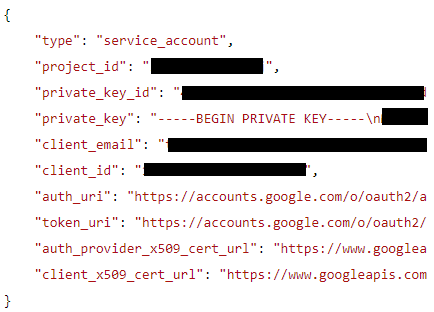 \
To read and write files from Cloud Storage:

In [ ]:
write_deltalake('gs://bucket-name/lake',
                df,
                storage_options = {'SERVICE_ACCOUNT': 
                'path_file.json'})

In [ ]:
DeltaTable('gs://bucket-name/lake',
           storage_options={'SERVICE_ACCOUNT':'path_file.json'})

* ***Azure***

The path to files from accepted is: \
* az://container/path

* adl://container/path

* abfs://container/path

`storage_options`:

AZURE_STORAGE_ACCOUNT_NAME \
AZURE_STORAGE_CONNECTION_STRING \
AZURE_STORAGE_ACCOUNT_KEY

You can see the source code with all parameters [here](https://github.com/delta-io/delta-rs/blob/17999d24a58fb4c98c6280b9e57842c346b4603a/rust/src/builder.rs#L524-L539)